### Reconstruction of the diffusion signal with the WMTI model

DKI can also be used to derive concrete biophysical parameters by applying microstructural models to DT and KT estimated from DKI. For instance, Fieremans et al. ([Fierem2011](https://www.sciencedirect.com/science/article/abs/pii/S1053811911006148)) showed that DKI can be converted to the parameters of two diffusion tensor model - a model that was later referred to as the white matter tract integrity WMTI technique ([Fierem2013](https://pubmed.ncbi.nlm.nih.gov/23764722/)). According to previous studies (e.g.[Hubber2018](https://www.sciencedirect.com/science/article/pii/S1878929318301348?via%3Dihub), [Fierem2013](https://pubmed.ncbi.nlm.nih.gov/23764722/), [Hui2012](https://pubmed.ncbi.nlm.nih.gov/22933581/)), this model showed to be useful to characterize microstructural alterations from health and disease.

In this example, we show how to process a dMRI dataset using the WMTI model.

First, we import all relevant modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dipy.reconst.dki as dki
import dipy.reconst.dki_micro as dki_micro
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.segment.mask import median_otsu
from scipy.ndimage.filters import gaussian_filter

C:\Users\rafae\AppData\Local\Temp\ipykernel_15412\1906085558.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


As the standard DKI, WMTI requires multi-shell data, i.e. data acquired from more than one non-zero b-value. Here, we use a fetcher to download the CFIN multi-shell dataset.

In [2]:
fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')

data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

## 1) Pre-processing

In this tutorial, noise suppression is done using Gaussian smoothing only for illustration purpose. When to denoise your data, please consider the advanced algorithms presented in the first day of the workshop (e.g. PCA denoising, path2self).

In [3]:
# data masking
maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                             autocrop=False, dilate=1)

# Smoothing
fwhm = 1.25
gauss_std = fwhm / np.sqrt(8 * np.log(2))
data_smooth = np.zeros(data.shape)
for v in range(data.shape[-1]):
    data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)

Before fitting this microstructural model, it is useful to indicate the regions in which this model provides meaningful information (i.e. voxels of well-aligned fibers). Following Fieremans et al. ([Fieremans2011](https://www.sciencedirect.com/science/article/abs/pii/S1053811911006148)), a simple way to select this region is to generate a well-aligned fiber mask based on the values of diffusion sphericity, planarity and linearity. Here we will follow these selection criteria for a better comparison of our figures with the original article published by Fieremans et al. ([Fieremans2011](https://www.sciencedirect.com/science/article/abs/pii/S1053811911006148)). Nevertheless, it is important to note that voxels with well-aligned fibers can be selected based on other approaches such as using predefined regions of interest.

In [4]:
# Diffusion Tensor is computed based on the standard DKI model
dkimodel = dki.DiffusionKurtosisModel(gtab)
dkifit = dkimodel.fit(data_smooth, mask=mask)

# Initialize well aligned mask with ones
well_aligned_mask = np.ones(data.shape[:-1], dtype='bool')

# Diffusion coefficient of linearity (cl) has to be larger than 0.4, thus
# we exclude voxels with cl < 0.4.
cl = dkifit.linearity.copy()
well_aligned_mask[cl < 0.4] = False

# Diffusion coefficient of planarity (cp) has to be lower than 0.2, thus
# we exclude voxels with cp > 0.2.
cp = dkifit.planarity.copy()
well_aligned_mask[cp > 0.2] = False

# Diffusion coefficient of sphericity (cs) has to be lower than 0.35, thus
# we exclude voxels with cs > 0.35.
cs = dkifit.sphericity.copy()
well_aligned_mask[cs > 0.35] = False

# Removing nan associated with background voxels
well_aligned_mask[np.isnan(cl)] = False
well_aligned_mask[np.isnan(cp)] = False
well_aligned_mask[np.isnan(cs)] = False

100%|███████████████████████████████████████████████████████████████████████████| 57580/57580 [07:30<00:00, 127.87it/s]


## 2) WMTI fitting

The WMTI model can be defined in DIPY by instantiating the ‘KurtosisMicrostructureModel’ object in the following way:

In [5]:
dki_micro_model = dki_micro.KurtosisMicrostructureModel(gtab)

Analogous to DKI, the data fit can be done by calling the fit function of the model’s object as follows:

In [6]:
dki_micro_fit = dki_micro_model.fit(data_smooth, mask=well_aligned_mask)

100%|███████████████████████████████████████████████████████████████████████████████| 465/465 [00:03<00:00, 125.62it/s]


The KurtosisMicrostructureFit object created by this fit function can then be used to extract model parameters such as the axonal water fraction and diffusion hindered tortuosity (defined as the ratio between extra-cellular axial and extra-cellular radial diffusivities):

In [7]:
AWF = dki_micro_fit.awf
TORT = dki_micro_fit.tortuosity

## 3) Data plotting
These parameters are plotted below on top of the mean kurtosis tensor maps:

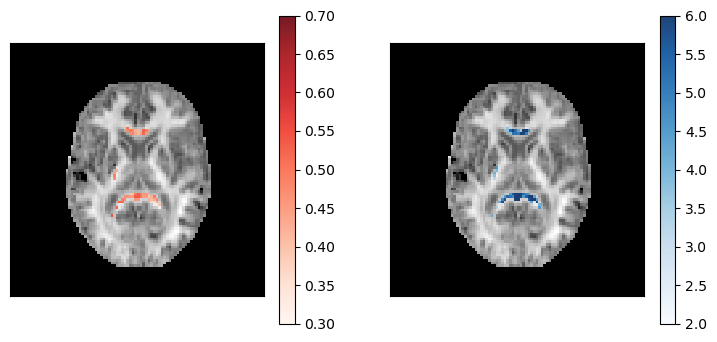

In [9]:
MK = dkifit.mkt(0, 3)

axial_slice = 9

fig1, ax = plt.subplots(1, 2, figsize=(9, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

AWF[AWF == 0] = np.nan
TORT[TORT == 0] = np.nan

ax[0].imshow(MK[:, :, axial_slice].T, cmap=plt.cm.gray,
             interpolation='nearest', origin='lower')
im0 = ax[0].imshow(AWF[:, :, axial_slice].T, cmap=plt.cm.Reds, alpha=0.9,
                   vmin=0.3, vmax=0.7, interpolation='nearest', origin='lower')
fig1.colorbar(im0, ax=ax.flat[0])

ax[1].imshow(MK[:, :, axial_slice].T, cmap=plt.cm.gray,
             interpolation='nearest', origin='lower')
im1 = ax[1].imshow(TORT[:, :, axial_slice].T, cmap=plt.cm.Blues, alpha=0.9,
                   vmin=2, vmax=6, interpolation='nearest', origin='lower')
fig1.colorbar(im1, ax=ax.flat[1])

fig1.savefig('Kurtosis_Microstructural_measures.png')

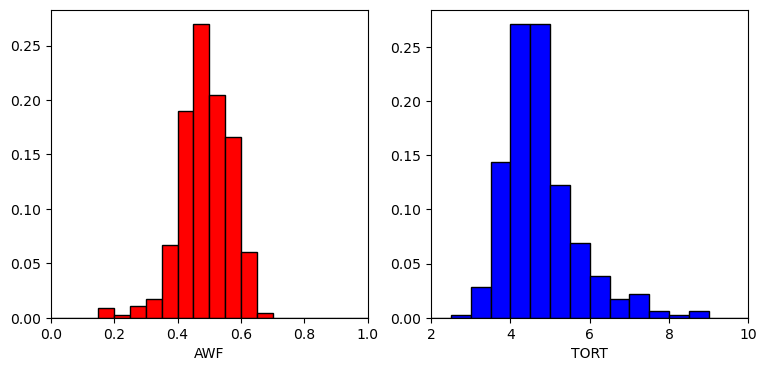

In [10]:
fig2, axs = plt.subplots(1, 2, figsize=(9, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

# Ploting histogram
x = AWF[well_aligned_mask].flatten()
x = x[~np.isnan(x)]
x = x[x > 0]
N, bins, patches = plt.hist(x, bins=20, range=(0, 1))
N = N / N.sum()
axs.flat[0].clear()
axs.flat[0].bar(bins[:-1] + 0.025, N, width=0.05,
                edgecolor=[0, 0, 0], color=[1, 0, 0])
axs.flat[0].set_xlabel('AWF')
axs.flat[0].set_xlim(0, 1)

x = TORT[well_aligned_mask].flatten()
x = x[~np.isnan(x)]
x = x[x > 0]
N, bins, patches = plt.hist(x, bins=20, range=(0, 10))
N = N / N.sum()
axs.flat[1].clear()
axs.flat[1].bar(bins[:-1] + 0.25, N, width=0.5,
                edgecolor=[0, 0, 0], color=[0, 0, 1])
axs.flat[1].set_xlabel('TORT')
axs.flat[1].set_xlim(2, 10)

fig2.savefig('WMTI_histograms.png', bbox_inches='tight')
plt.show()

# References

For more information, you can read the paper describing the implementation details of DKI and derived metrics described in the following paper:

[Henriques et al. Diffusional Kurtosis Imaging in the Diffusion Imaging in Python Project. Front. Hum. Neurosci. 2021](https://www.frontiersin.org/articles/10.3389/fnhum.2021.675433/full)